In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titleweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 14 
plt.rcParams['axes.labelsize'] = 12 

In [36]:
file_paths = {
    'Netflix': 'data_netflix.csv',
    'Prime Video': 'data_prime_video.csv',
    'Max': 'data_hbo_max.csv',
    'Apple TV': 'data_apple_tv.csv'
}

dataframes = []

print("carregamento dos dados")
for platform_name, file_path in file_paths.items():
    try:
        df = pd.read_csv(file_path)
        df['platform'] = platform_name
        dataframes.append(df)
        print(f"Dados de '{platform_name}' carregados com sucesso.")
    except FileNotFoundError:
        print(f"AVISO: O arquivo '{file_path}' não foi encontrado. Ignorando esta plataforma.")
    except Exception as e:
        print(f"ERRO ao carregar '{file_path}': {e}")


if dataframes:
    df_combined = pd.concat(dataframes, ignore_index=True)
    print("\nTodos os DataFrames foram concatenados com sucesso em 'df_combined'.")
    print(f"Total de linhas carregadas: {len(df_combined)}")
else:
    print("\nNenhum dado foi carregado. 'df_combined' não pôde ser criado.")
  
    df_combined = pd.DataFrame()

carregamento dos dados
Dados de 'Netflix' carregados com sucesso.
Dados de 'Prime Video' carregados com sucesso.
Dados de 'Max' carregados com sucesso.
Dados de 'Apple TV' carregados com sucesso.

Todos os DataFrames foram concatenados com sucesso em 'df_combined'.
Total de linhas carregadas: 123922


## Pré Processamento e Limpeza dos Dados ##

In [37]:
initial_rows = len(df_combined)
df_combined.dropna(subset=['title', 'genres', 'imdbAverageRating', 'imdbNumVotes'], inplace=True)


In [38]:
df.fillna({'availableCountries':'Não Especificado'}, inplace=True)

In [39]:
df_combined['releaseYear'] = df_combined['releaseYear'].astype(int)
df_combined['imdbAverageRating'] = pd.to_numeric(df_combined['imdbAverageRating'])
df_combined['imdbNumVotes'] = pd.to_numeric(df_combined['imdbNumVotes'])
print("Tipos de dados convertidos para 'releaseYear', 'imdbAverageRating' e 'imdbNumVotes'.")


Tipos de dados convertidos para 'releaseYear', 'imdbAverageRating' e 'imdbNumVotes'.


In [40]:
df_temp_genres = df_combined.copy() 

In [41]:
df_temp_genres['genres'] = df_temp_genres['genres'].astype(str).apply(
    lambda x: [g.strip() for g in x.split(',') if g.strip()] if x and x.strip() else [])

In [42]:
df_processed_genres = df_temp_genres[df_temp_genres['genres'].apply(len) > 0].copy()

In [43]:
df_exploded_genres = df_processed_genres.explode('genres').copy()

### ANÁLISE EXPLORATIVA ENTRE PLATAFORMAS ###

In [44]:
if df_combined.empty:
    print("AVISO: O DataFrame 'df_combined' está vazio. Não é possível calcular o total de títulos por plataforma. Verifique as etapas anteriores de carregamento e limpeza.")
else:
    total_titles_per_platform = df_combined['platform'].value_counts().reset_index(name='Total Titles')
    total_titles_per_platform.rename(columns={'index': 'Platform'}, inplace=True)

    print("Total de Títulos por Plataforma:\n", total_titles_per_platform)

Total de Títulos por Plataforma:
       platform  Total Titles
0  Prime Video         63887
1      Netflix         19986
2     Apple TV         16678
3          Max          9074


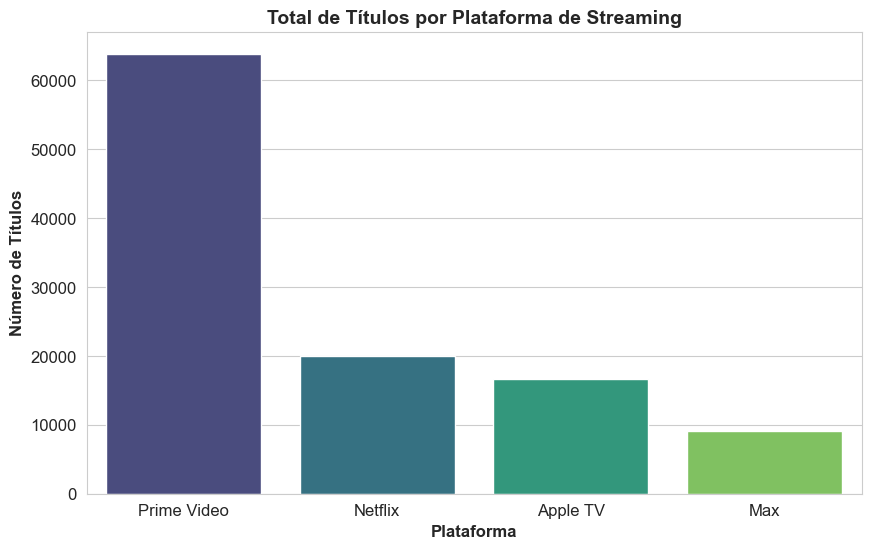

In [45]:
    if total_titles_per_platform.empty:
        print("AVISO: 'total_titles_per_platform' está vazio após a contagem de valores. Não há dados válidos de plataforma para plotar.")
    else: 
        plt.figure(figsize=(10, 6))
        sns.barplot(x='platform', y='Total Titles', data=total_titles_per_platform,
                    palette='viridis', hue='platform', legend=False)
        plt.title('Total de Títulos por Plataforma de Streaming')
        plt.xlabel('Plataforma')
        plt.ylabel('Número de Títulos')
        plt.show()

## Proporção de Filmes e Séries por Plataforma ##

Proporção de Filmes vs. Séries por Plataforma:
 type            movie        tv
platform                       
Apple TV     0.778690  0.221310
Max          0.668724  0.331276
Netflix      0.771240  0.228760
Prime Video  0.881118  0.118882

Proporção de Filmes vs. Séries por Plataforma (em %):
 type          movie      tv
platform                   
Apple TV     77.87%  22.13%
Max          66.87%  33.13%
Netflix      77.12%  22.88%
Prime Video  88.11%  11.89%


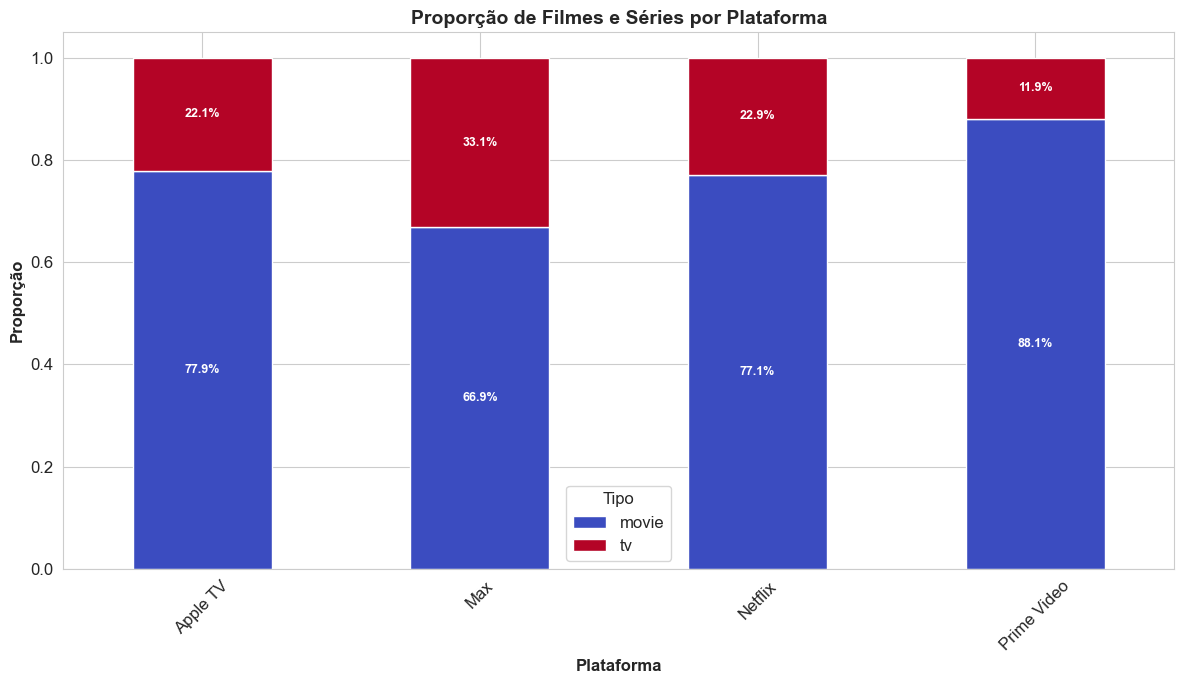

In [46]:
type_distribution = df_combined.groupby('platform')['type'].value_counts(normalize=True).unstack(fill_value=0)
print("Proporção de Filmes vs. Séries por Plataforma:\n", type_distribution)

type_distribution_percentage = type_distribution * 100
print("\nProporção de Filmes vs. Séries por Plataforma (em %):\n", type_distribution_percentage.map(lambda x: f"{x:.2f}%"))

ax = type_distribution.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='coolwarm')
plt.title('Proporção de Filmes e Séries por Plataforma')
plt.xlabel('Plataforma')
plt.ylabel('Proporção')
plt.xticks(rotation=45)
plt.legend(title='Tipo')

for c in ax.containers:
    labels = [f'{w:.1%}' if (w := v.get_height()) > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=9, color='white', weight='bold')

plt.tight_layout()
plt.show()


## Plataforma com Filmes Mais Bem Avaliados ##

In [47]:
min_votes_threshold = 1000 
df_filtered_by_votes = df_combined[df_combined['imdbNumVotes'] >= min_votes_threshold].copy()


Média de Avaliação IMDb por Plataforma (títulos com >= 1000 votos):
       platform  imdbAverageRating
0          Max           6.799553
1      Netflix           6.597938
2     Apple TV           6.451636
3  Prime Video           6.175376


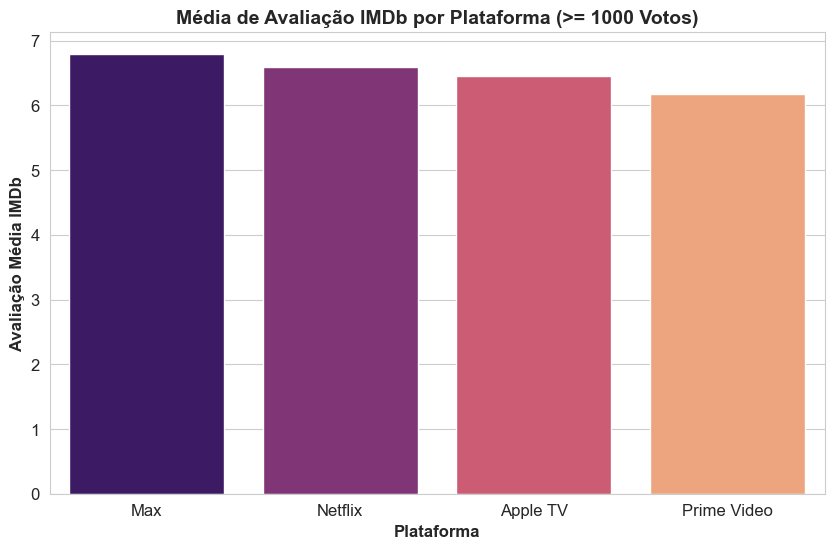

In [48]:
if df_filtered_by_votes.empty:
    print(f"\nNão há títulos com >= {min_votes_threshold} votos para analisar a qualidade IMDb. Ajuste o threshold se necessário.")
else:

    avg_rating_per_platform = df_filtered_by_votes.groupby('platform')['imdbAverageRating'].mean().sort_values(ascending=False).reset_index(name='imdbAverageRating')

    print(f"\nMédia de Avaliação IMDb por Plataforma (títulos com >= {min_votes_threshold} votos):\n", avg_rating_per_platform)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='platform', y='imdbAverageRating', data=avg_rating_per_platform,
                palette='magma', hue='platform', legend=False)
    plt.title(f'Média de Avaliação IMDb por Plataforma (>= {min_votes_threshold} Votos)')
    plt.xlabel('Plataforma')
    plt.ylabel('Avaliação Média IMDb')
    plt.show()

## Distribuição por Ano de Lançamento por Plataforma ##

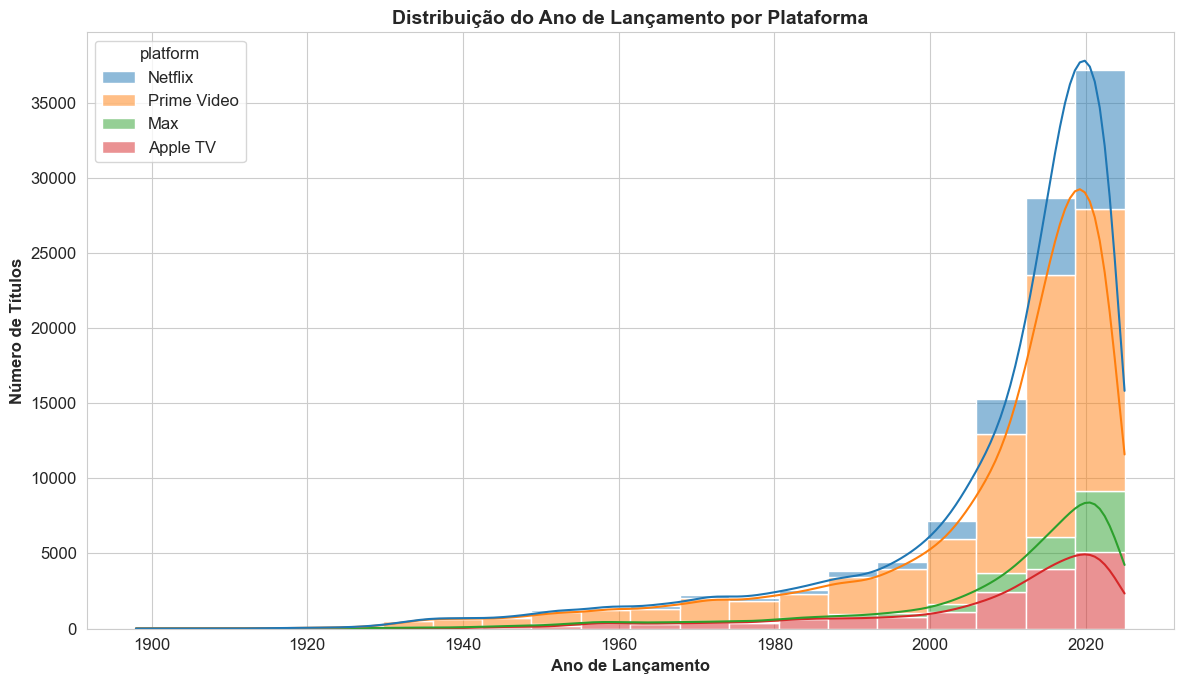

In [49]:
plt.figure(figsize=(12, 7))

ax = sns.histplot(data=df_combined, x='releaseYear', hue='platform', kde=True, multiple='stack', palette='tab10', bins=20)
plt.title('Distribuição do Ano de Lançamento por Plataforma')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Número de Títulos')


plt.tight_layout() 
plt.show()

### ANÁLISES PONTUAIS PARA NETFLIX ###

## Top Gêneros na Netflix ##

In [50]:
df_netflix_only = df_exploded_genres[df_exploded_genres['platform'] == 'Netflix'].copy()

if df_netflix_only.empty:
    print("DataFrame 'df_netflix_only' está vazio. Análises para Netflix não podem ser executadas.")

In [51]:
if df_netflix_only.empty:
    print("\nNão há dados disponíveis para a Netflix após o pré-processamento.")
else: 
    print("\n--- Perfil Médio dos Títulos Netflix ---")
    print(f"Média de Avaliação IMDb: {df_netflix_only['imdbAverageRating'].mean():.2f}")
    print(f"Ano Médio de Lançamento: {df_netflix_only['releaseYear'].mean():.0f}")

    netflix_genres_exploded = df_netflix_only.explode('genres').copy()
    top_netflix_genres = netflix_genres_exploded['genres'].value_counts().head(5).reset_index(name='count')
    top_netflix_genres.rename(columns={'index': 'Genre'}, inplace=True)

    print("\nTop 5 Gêneros na Netflix:\n", top_netflix_genres)


--- Perfil Médio dos Títulos Netflix ---
Média de Avaliação IMDb: 6.43
Ano Médio de Lançamento: 2013

Top 5 Gêneros na Netflix:
     genres  count
0    Drama   9640
1   Comedy   7343
2   Action   3464
3    Crime   3063
4  Romance   3006


## Títulos Evergreen que a Netflix possui no catálogo ##

In [52]:
evergreen_min_rating = 7.5
evergreen_min_votes = 10000
current_year = pd.Timestamp.now().year
evergreen_max_release_year = current_year - 10

if df_netflix_only.empty:
    print("Não há dados da Netflix para identificar títulos Evergreen.")
else:
    df_netflix_evergreen = df_netflix_only[
        (df_netflix_only['imdbAverageRating'] >= evergreen_min_rating) &
        (df_netflix_only['imdbNumVotes'] >= evergreen_min_votes) &
        (df_netflix_only['releaseYear'] <= evergreen_max_release_year)
    ].copy()

    print(f"\n--- Títulos Evergreen na Netflix (Rating >= {evergreen_min_rating}, Votos >= {evergreen_min_votes}, Lançamento <= {evergreen_max_release_year}) ---")
    if not df_netflix_evergreen.empty:
        print(df_netflix_evergreen[['title', 'releaseYear', 'genres', 'imdbAverageRating', 'imdbNumVotes']].sort_values(by='imdbAverageRating', ascending=False).head(10))
    else:
        print("Nenhum título 'Evergreen' encontrado com os critérios definidos na Netflix.")



--- Títulos Evergreen na Netflix (Rating >= 7.5, Votos >= 10000, Lançamento <= 2015) ---
                            title  releaseYear     genres  imdbAverageRating  \
16507                Breaking Bad         2008   Thriller                9.5   
16507                Breaking Bad         2008      Crime                9.5   
16507                Breaking Bad         2008      Drama                9.5   
16576            Band of Brothers         2001      Drama                9.4   
16576            Band of Brothers         2001     Action                9.4   
16576            Band of Brothers         2001    History                9.4   
81       The Shawshank Redemption         1994      Drama                9.3   
16481  Avatar: The Last Airbender         2005     Action                9.3   
16481  Avatar: The Last Airbender         2005  Adventure                9.3   
16481  Avatar: The Last Airbender         2005  Animation                9.3   

       imdbNumVotes  
16507  


Top 5 Gêneros dos Títulos Evergreen na Netflix:
       genres  count
0      Drama    512
1     Comedy    200
2     Action    182
3      Crime    170
4  Adventure    149


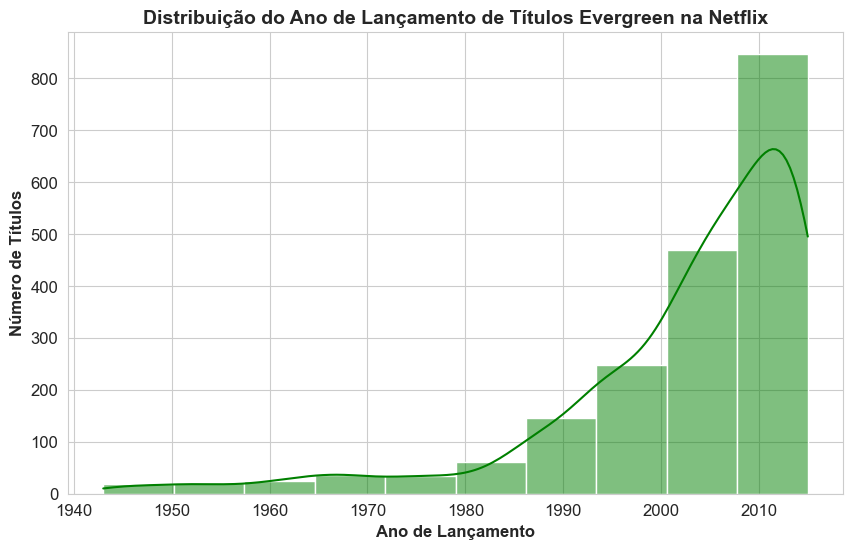

In [53]:
if not df_netflix_evergreen.empty:
        evergreen_genres = df_netflix_evergreen.explode('genres')['genres'].value_counts().head(5).reset_index(name='count')
        evergreen_genres.rename(columns={'index': 'Genre'}, inplace=True)
        print("\nTop 5 Gêneros dos Títulos Evergreen na Netflix:\n", evergreen_genres)

        plt.figure(figsize=(10, 6))
        sns.histplot(df_netflix_evergreen['releaseYear'], bins=10, kde=True, color='green')
        plt.title('Distribuição do Ano de Lançamento de Títulos Evergreen na Netflix')
        plt.xlabel('Ano de Lançamento')
        plt.ylabel('Número de Títulos')
        plt.show()
else:
        print("Não foi possível analisar os gêneros de títulos 'Evergreen' devido à falta de dados.")

## Pontos a Melhorar da Netflix em Comparação com Outras Plataformas ##

In [54]:
high_quality_titles = df_combined[
    (df_combined['imdbAverageRating'] >= 8.0) &
    (df_combined['imdbNumVotes'] >= 20000)
].copy()

high_quality_count_per_platform = high_quality_titles['platform'].value_counts().reset_index(name='High Quality Titles')
high_quality_count_per_platform.rename(columns={'index': 'Platform'}, inplace=True)

print("\n--- Número de Títulos de Alta Qualidade por Plataforma (Rating >= 8.0, Votos >= 20000) ---\n", high_quality_count_per_platform)




--- Número de Títulos de Alta Qualidade por Plataforma (Rating >= 8.0, Votos >= 20000) ---
       platform  High Quality Titles
0  Prime Video                  632
1      Netflix                  487
2          Max                  353
3     Apple TV                  322


# Comparativo Médias Avaliação IMDB #

In [55]:
if 'df_filtered_by_votes' not in locals() or df_filtered_by_votes.empty:
    min_votes_threshold = 1000
    df_filtered_by_votes = df_combined[df_combined['imdbNumVotes'] >= min_votes_threshold].copy()

if not df_filtered_by_votes.empty and not df_netflix_only.empty:
    avg_rating_global = df_filtered_by_votes['imdbAverageRating'].mean()
    netflix_avg_rating = df_netflix_only['imdbAverageRating'].mean()

    print(f"\n--- Comparativo da Média de Avaliação IMDb ---")
    print(f"Média de Avaliação IMDb (global, com >= {min_votes_threshold} votos): {avg_rating_global:.2f}")
    print(f"Média de Avaliação IMDb (Netflix): {netflix_avg_rating:.2f}")




--- Comparativo da Média de Avaliação IMDb ---
Média de Avaliação IMDb (global, com >= 1000 votos): 6.39
Média de Avaliação IMDb (Netflix): 6.43


### Análise de variação da qualidade ao longo do tempo ###

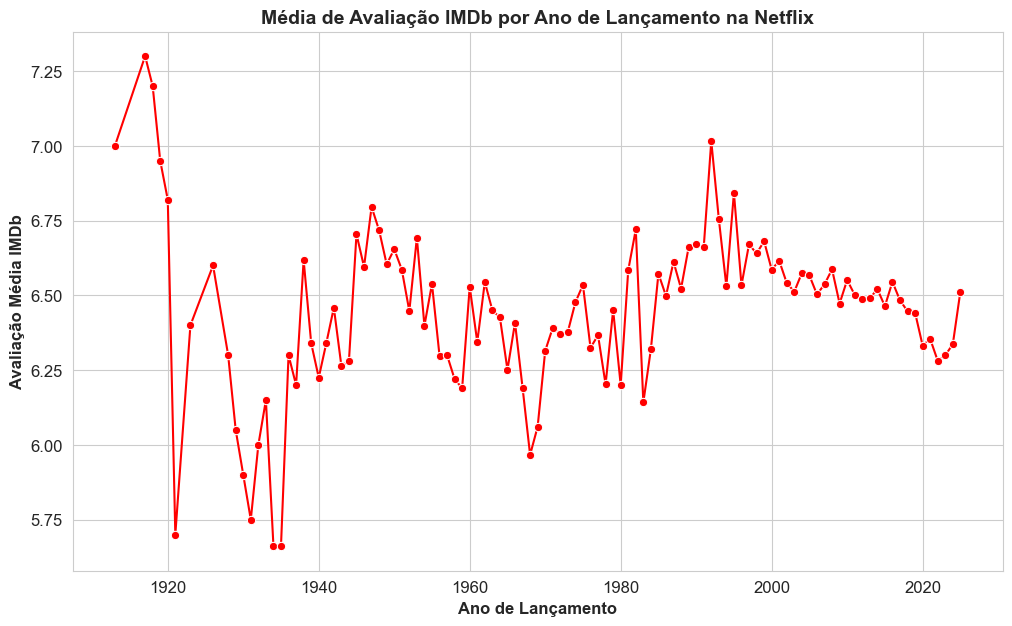

In [56]:
if df_netflix_only.empty:
    print("Não há dados da Netflix para analisar a variação de qualidade ao longo do tempo.")
else:
    avg_rating_by_year_netflix = df_netflix_only.groupby('releaseYear')['imdbAverageRating'].mean().reset_index()

    plt.figure(figsize=(12, 7))
    sns.lineplot(x='releaseYear', y='imdbAverageRating', data=avg_rating_by_year_netflix, marker='o', color='red')
    plt.title('Média de Avaliação IMDb por Ano de Lançamento na Netflix')
    plt.xlabel('Ano de Lançamento')
    plt.ylabel('Avaliação Média IMDb')
    plt.show()


--- Média de Votos IMDb por Plataforma (títulos com >= 1000 votos) ---
       Platform  imdbNumVotes
0          Max  97400.869309
1      Netflix  55629.877837
2     Apple TV  46867.160724
3  Prime Video  35103.707190


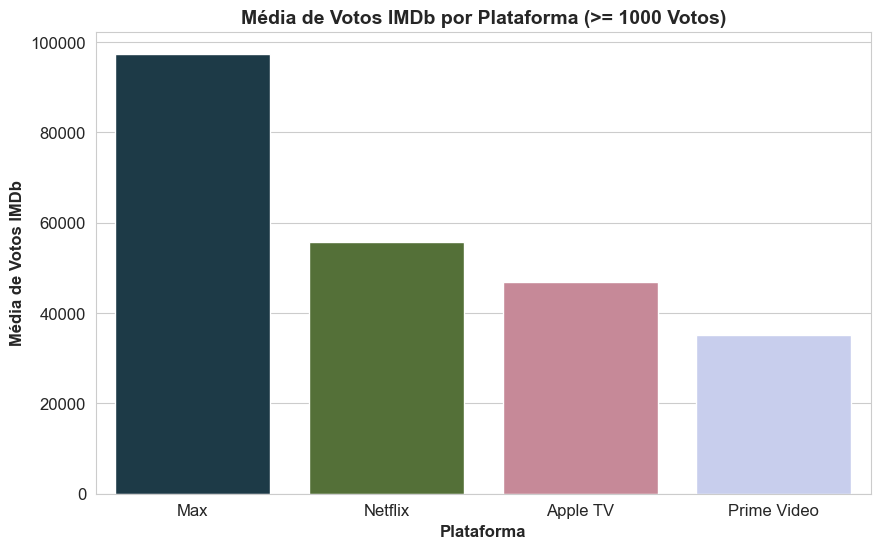

In [57]:
if 'df_filtered_by_votes' not in locals() or df_filtered_by_votes.empty:
    min_votes_threshold = 1000
    df_filtered_by_votes = df_combined[df_combined['imdbNumVotes'] >= min_votes_threshold].copy()

if not df_filtered_by_votes.empty:
    avg_votes_per_platform = df_filtered_by_votes.groupby('platform')['imdbNumVotes'].mean().sort_values(ascending=False).reset_index(name='imdbNumVotes')
    avg_votes_per_platform.rename(columns={'platform': 'Platform'}, inplace=True)

    print(f"\n--- Média de Votos IMDb por Plataforma (títulos com >= {min_votes_threshold} votos) ---\n", avg_votes_per_platform)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Platform', y='imdbNumVotes', data=avg_votes_per_platform,
                palette='cubehelix', hue='Platform', legend=False)
    plt.title(f'Média de Votos IMDb por Plataforma (>= {min_votes_threshold} Votos)')
    plt.xlabel('Plataforma')
    plt.ylabel('Média de Votos IMDb')
    plt.show()
else:
    print("Não foi possível analisar a média de votos devido à falta de dados filtrados por votos.")

In [58]:
if df_netflix_only.empty:
    print("\nNão há dados disponíveis para a Netflix após o pré-processamento.")
else:
    print("\n--- Perfil Médio dos Títulos Netflix ---")
    print(f"Média de Avaliação IMDb: {df_netflix_only['imdbAverageRating'].mean():.2f}")
    print(f"Ano Médio de Lançamento: {df_netflix_only['releaseYear'].mean():.0f}")


--- Perfil Médio dos Títulos Netflix ---
Média de Avaliação IMDb: 6.43
Ano Médio de Lançamento: 2013



--- Qualidade e Popularidade por Tipo de Conteúdo na Netflix ---

Média de Avaliação e Votos por Tipo de Conteúdo (Netflix):
     type  avg_rating     avg_votes
0  movie    6.233773  44548.486752
1     tv    7.071584  18594.525897


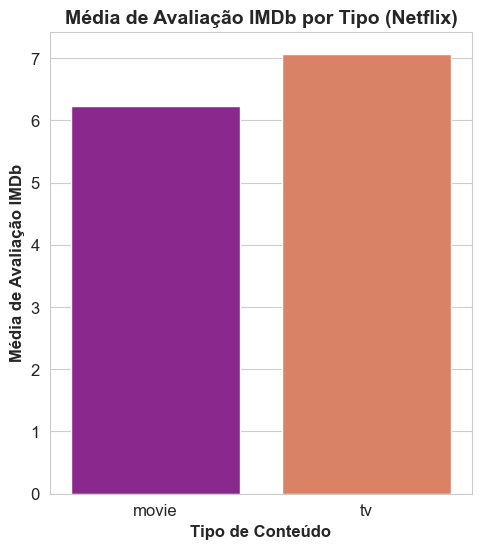

In [59]:
if df_netflix_only.empty:
    print("Não há dados da Netflix para analisar a qualidade e popularidade por tipo de conteúdo.")
else:
    print("\n--- Qualidade e Popularidade por Tipo de Conteúdo na Netflix ---")
    netflix_type_analysis = df_netflix_only.groupby('type').agg(
        avg_rating=('imdbAverageRating', 'mean'),
        avg_votes=('imdbNumVotes', 'mean')
    ).reset_index()


    print("\nMédia de Avaliação e Votos por Tipo de Conteúdo (Netflix):\n", netflix_type_analysis)


    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1) 
    sns.barplot(x='type', y='avg_rating', data=netflix_type_analysis, palette='plasma', hue='type', legend=False)
    plt.title('Média de Avaliação IMDb por Tipo (Netflix)')
    plt.xlabel('Tipo de Conteúdo')
    plt.ylabel('Média de Avaliação IMDb')

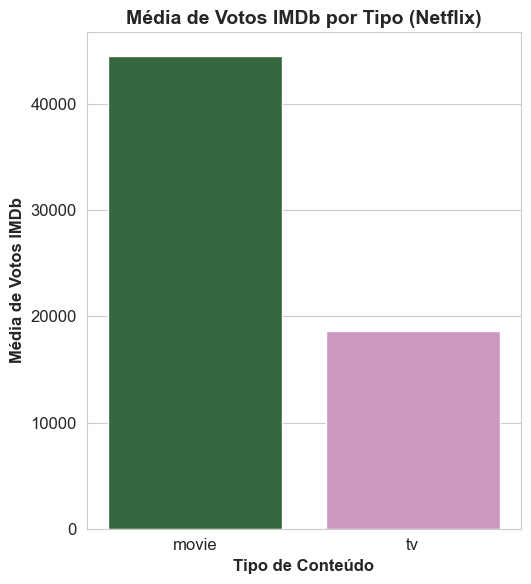

In [60]:
    plt.subplot(1, 2, 2) 
    sns.barplot(x='type', y='avg_votes', data=netflix_type_analysis, palette='cubehelix', hue='type', legend=False)
    plt.title('Média de Votos IMDb por Tipo (Netflix)')
    plt.xlabel('Tipo de Conteúdo')
    plt.ylabel('Média de Votos IMDb')


    plt.tight_layout()
    plt.show()
